In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import os, gc
import seaborn as sns

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

sns.set(context='notebook', style='whitegrid', palette='deep', font='sans-serif', 
        font_scale=2, color_codes=True, rc=None)

In [2]:
train_test = pd.read_csv('data/train_test.csv')
train_test.shape

(488189, 62)

In [3]:
train_len = 341424

train_df = train_test.iloc[:train_len]
test_df  = train_test.iloc[train_len:]
test_df = test_df.reset_index(drop=True)

target = train_df['amount_spent_per_room_night_scaled']

train_df.drop('amount_spent_per_room_night_scaled', axis=1, inplace=True)
test_df.drop('amount_spent_per_room_night_scaled', axis=1, inplace=True)

print(train_df.shape, test_df.shape, target.shape)

print("Shape: ", train_df.shape, " ==> ", end=" ")

train_df.drop(['booking_date','checkin_date','checkout_date'], axis=1, inplace=True)
test_df.drop(['booking_date','checkin_date','checkout_date'], axis=1, inplace=True)

print(train_df.shape)


(341424, 61) (146765, 61) (341424,)
Shape:  (341424, 61)  ==>  (341424, 58)


In [4]:
len(set(train_df.memberid)), len(set(test_df.memberid)), len(set(train_df.memberid).intersection(set(test_df.memberid)))

(101327, 43496, 0)

In [5]:
for col in train_df.columns:
    train_df[col] = train_df[col].astype('category').cat.codes

In [6]:
from sklearn.model_selection import GroupKFold, GroupShuffleSplit

group_kfold = GroupKFold(n_splits=4)

print(group_kfold)

for train_index, test_index in group_kfold.split(train_df.drop('memberid', axis=1), target, train_df['memberid']):
#     print("TRAIN:", train_index, "TEST:", test_index)
    train_, valid_ = train_df.iloc[train_index], train_df.iloc[test_index]
    y_tr, y_val    = target[train_index], target[test_index]
    break

train_.shape, valid_.shape, y_tr.shape, y_val.shape

GroupKFold(n_splits=4)


((256068, 58), (85356, 58), (256068,), (85356,))

In [7]:
train_.drop('memberid', axis=1, inplace=True)
valid_.drop('memberid', axis=1, inplace=True)

In [8]:
del train_df, test_df, train_test
gc.collect()

21

In [9]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization

def bayesian_opt_lgb(X_train, y_train, X_valid, y_valid, features):
        
    def train_lgb_model(f_frac, b_frac, 
                        l1, l2, split_gain,
                        leaves, data_in_leaf, hessian):
    
        param = {}

        param['feature_fraction'] = max(min(f_frac, 1), 0)
        param['bagging_fraction'] = max(min(b_frac, 1), 0)

        param['lambda_l1'] = max(l1, 0)
        param['lambda_l2'] = max(l2, 0)
        param['min_split_gain'] = split_gain
#     #     params['min_child_weight'] = min_child_weight

        param['num_leaves'] = int(leaves)
        param['min_data_in_leaf'] = int(data_in_leaf)
        param['min_sum_hessian_in_leaf'] = max(hessian, 0)

        param_const = {
            'max_bins'               : 63,
            'learning_rate'          : 0.01,
            'num_threads'            : 4,
            'metric'                 : 'rmse',
            'boost'                  : 'gbdt',
            'tree_learner'           : 'serial',
            'objective'              : 'root_mean_squared_error',
            'verbosity'              : 0,
        }

        for key, item in param_const.items():
            param[key] = item
    
#         print(param)

        _train = lgb.Dataset(X_train[features], label=y_train, feature_name=list(features))
        _valid = lgb.Dataset(X_valid[features], label=y_valid,feature_name=list(features))

        clf = lgb.train(param, _train, 10000, 
                        valid_sets = [_train, _valid], 
                        verbose_eval=0, 
                        early_stopping_rounds = 25)                  

        oof = clf.predict(X_valid[features], num_iteration=clf.best_iteration)
        score = mean_squared_error(y_valid, oof)

        return -score


    _bo = BayesianOptimization(train_lgb_model, {
        # speed
#         'bagging_freq'           : 5, #int
        'b_frac'       : (0.2,0.7),
        'f_frac'       : (0.2,0.8),

#         # accuracy
# #         'max_bins'               : 127,
#         'learning_rate'          : 0.01,
        'leaves'             : (20,90), # int
    
        # regularization
        'split_gain'      : (0, 10),
        'l1'              : (0, 5),
        'l2'              : (0, 5),
        
#         # deal with overfitting
        'data_in_leaf'       : (20, 500), # int
        'hessian': (0, 100),


    }, random_state=23456)
    _bo.maximize(init_points=25, n_iter=12, acq='ei')
    
    return _bo

In [164]:
bo_tuning_lgb = bayesian_opt_lgb(train_, y_tr, valid_, y_val, list(train_.columns))


|   iter    |  target   |  b_frac   | data_i... |  f_frac   |  hessian  |    l1     |    l2     |  leaves   | split_... |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -0.9448   |  0.3609   |  177.1    |  0.7565   |  31.17    |  0.8098   |  1.82     |  57.05    |  7.891    |
|  2        | -0.9448   |  0.6377   |  325.6    |  0.7938   |  81.59    |  0.2066   |  1.015    |  30.67    |  7.531    |
|  3        | -0.9437   |  0.4276   |  478.2    |  0.7624   |  13.54    |  1.18     |  1.574    |  67.09    |  6.206    |
|  4        | -0.9471   |  0.5111   |  422.2    |  0.5785   |  56.09    |  4.934    |  3.416    |  27.09    |  9.401    |
|  5        | -0.947    |  0.5257   |  129.2    |  0.4591   |  39.01    |  3.779    |  0.7132   |  20.69    |  8.379    |
|  6        | -0.9447   |  0.2544   |  139.6    |  0.4855   |  88.39    |  0.8874   |  3.93     |  22.45    |  6.086    |
|  7        | -0.9392   

In [10]:
from catboost import Pool, CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization

def bayesian_opt_cat(X_train, y_train, X_valid, y_valid, features):
        
    def train_cat_model(r_str, b_temp, l2, depth):
    
        params = {}

        params['random_strength']     = max(min(r_str, 1), 0)
        params['bagging_temperature'] = max(b_temp, 0)
        
        params['l2_leaf_reg'] = max(l2, 0)
#         params['min_data_in_leaf'] = max(data_leaf,1)
        
#         params['subsample'] = subsample
        params['depth']     = int(depth)

        param_const = {
            'border_count'          : 63,
            'early_stopping_rounds' : 50,
            'random_seed'           : 1337,
            'task_type'             : 'CPU', 
            'loss_function'         : "RMSE", 
    #         'subsample'             = 0.7, 
            'iterations'            : 10000, 
            'learning_rate'         : 0.01,
            'thread_count'          : 4,
#             'bootstrap_type'        : 'No'
        }

        for key, item in param_const.items():
            params[key] = item
    
        

        _train = Pool(X_train[features], label=y_train)#, cat_features=cate_features_index)
        _valid = Pool(X_valid[features], label=y_valid)#, cat_features=cate_features_index)

        watchlist = [_train, _valid]
        clf = CatBoostRegressor(**params)
        clf.fit(_train, 
                eval_set=watchlist, 
                verbose=0,
                use_best_model=True)

        oof  = clf.predict(X_valid[features])

        score = mean_squared_error(y_valid, oof)

        return -score

    _bo = BayesianOptimization(train_cat_model, {

        'r_str'      : (1, 5),
        'b_temp'     : (0.01, 100),
        'depth'      : (3,8), # int
#         'subsample'  : (0.3, 0.8),
#         'data_leaf'  : (2,7),
        'l2'         : (0, 5),

    }, random_state=23456)
    _bo.maximize(init_points=25, n_iter=12, acq='ei')
    
    return _bo



In [166]:
bo_tuning_cat = bayesian_opt_cat(train_, y_tr, valid_, y_val, list(train_.columns))


|   iter    |  target   |  b_temp   |   depth   |    l2     |   r_str   |
-------------------------------------------------------------------------
|  1        | -0.9559   |  32.19    |  4.637    |  4.637    |  2.247    |
|  2        | -0.9538   |  16.2     |  4.82     |  2.646    |  4.156    |
|  3        | -1.183    |  87.54    |  6.183    |  4.949    |  4.264    |
|  4        | -0.9494   |  4.141    |  4.015    |  0.762    |  4.012    |
|  5        | -1.183    |  45.52    |  7.773    |  4.687    |  1.542    |
|  6        | -0.9549   |  23.6     |  4.574    |  3.363    |  3.482    |
|  7        | -1.183    |  62.22    |  7.189    |  3.154    |  3.244    |
|  8        | -1.183    |  98.69    |  6.416    |  0.5066   |  4.76     |
|  9        | -1.183    |  65.14    |  4.137    |  2.159    |  2.56     |
|  10       | -1.183    |  75.58    |  3.713    |  0.04931  |  4.352    |
|  11       | -0.9532   |  10.89    |  4.246    |  2.379    |  4.536    |
|  12       | -0.9463   |  17.76    | 

In [171]:
bo_tuning_lgb.max

{'target': -0.9362267064104927,
 'params': {'b_frac': 0.3677516358370858,
  'data_in_leaf': 495.44417416221626,
  'f_frac': 0.5422060360159515,
  'hessian': 5.039378213231793,
  'l1': 1.0642598045225304,
  'l2': 2.564544963055539,
  'leaves': 89.62655396835916,
  'split_gain': 0.16542750189034394}}

In [172]:
bo_tuning_cat.max

{'target': -0.9366723276780314,
 'params': {'b_temp': 0.08307474720468191,
  'depth': 7.596402546589758,
  'l2': 3.9791105400066655,
  'r_str': 1.1206250787323229}}

In [173]:
train_1 = train_.copy()
valid_1 = valid_.copy()

train_1.shape, valid_1.shape

((256068, 57), (85356, 57))

In [175]:

import pandas as pd
import numpy as np
import gc
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

def get_normalization(train_df, test_df, which_norm=None, int_cols=None, cat_cols=None):
    """ normalization of data features
    Args:
        train_df, test_df
        which_norm: normalization for numerical columns, ['stdc', 'min-max']
        int_cols: list of numerical_columns
        cat_cols: list of categorical columns
    Return:
        standarization scaled version for numeric data
        min-max scaled version for categorical data
    example:

        from sklearn import datasets
        iris = datasets.load_iris()
        X = iris.data; y = iris.target
        X = pd.DataFrame(data=X, columns=iris['feature_names'])
        get_normalization(X.iloc[:10,:], X.iloc[10:15,:], 'min-max',int_cols=X.columns)
        get_normalization(X.iloc[:10,:], X.iloc[10:15,:], int_cols='sepal width (cm)')
        get_normalization(X.iloc[:10,:], X.iloc[10:15,:], int_cols=X.columns)
    """
    complete_df = pd.concat([train_df, test_df], axis=0)

    stdc = StandardScaler()
    min_max = MinMaxScaler()

    if int_cols is not None:
        if which_norm == 'stdc': norm = StandardScaler()
        elif which_norm == 'min-max': norm = MinMaxScaler()
        else: 
            norm = StandardScaler()
            print("by default: stdc norm is running")
        try: 
            complete_df[int_cols] = norm.fit_transform(complete_df[int_cols])
        except: 
            # expecting a 2d array, but passed i-d array
            complete_df[[int_cols]] = norm.fit_transform(complete_df[[int_cols]])
        print("done with stdc normalization on numerical columns")
        
    if cat_cols is not None:
        norm = MinMaxScaler()
        try: 
            complete_df[cat_cols] = norm.fit_transform(complete_df[cat_cols])
        except:
            complete_df[[cat_cols]] = norm.fit_transform(complete_df[[cat_cols]])
        print("done with min-max normalization on categorical columns")

    train_df_new = complete_df.iloc[:train_df.shape[0],:]
    test_df_new  = complete_df.iloc[train_df.shape[0]:,:]
#     print(train_df_new.shape, test_df_new.shape)
    
    test_df_new = test_df_new.reset_index(drop=True)
    
    del complete_df
    gc.collect()
    return train_df_new, test_df_new
    


In [176]:
train_1, valid_1 = get_normalization(train_1, valid_1, cat_cols=list(train_1.columns))

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:334: DataConversionWarning: Data with input dtype int8, int16 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


done with min-max normalization on categorical columns


In [178]:

import numpy as np
import pandas as pd
import gc

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import BayesianRidge
from sklearn.svm import SVR

from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.svm import SVC

def regression_model(reg_name):

    if clf_name == 'bayesian_ridge':
        params = {'alpha1' : 0.1, 
                  'alpha2' : 0.1,
                  'lambda1': 0.1,
                  'lambda2': 0.1}   
    else:
        params = {'alpha': 0.1}   


    if reg_name == 'bayesian_ridge':
        reg = BayesianRidge(
            n_iter=300, tol=0.001, compute_score=False,
            alpha_1=params['alpha1'], alpha_2=params['alpha2'], 
            lambda_1=params['lambda1'], lambda_2=params['lambda2'],  
            fit_intercept=True, normalize=True, verbose=False)

    elif reg_name is 'linear':
        reg = LinearRegression(fit_intercept=True, normalize=True, n_jobs=-1)

    elif reg_name is 'lasso':
        reg = Lasso(
            alpha=params['alpha'], fit_intercept=True, normalize=True, 
            positive=False, random_state=1234, selection='cyclic')

    
    elif reg_name is 'elastic_net':
        reg = ElasticNet(
            alpha=params['alpha'], l1_ratio=0.5, fit_intercept=True, 
            normalize=True, random_state=1234, selection='cyclic')
    
    elif reg_name is 'ridge':
        reg = Ridge(
            alpha=params['alpha'], fit_intercept=True, normalize=True, 
            max_iter=500, random_state=1234)

    elif reg_name is 'kernel_ridge':
        reg = KernelRidge(
            alpha=params['alpha'], kernel=kernel_func, gamma=None, 
            degree=degree, coef0=1, kernel_params=None)
    
    elif reg_name is 'svm':
        reg = SVR(
            kernel=kernel_func, degree=degree, coef0=0.0, tol=0.001, 
            C=params['alpha'], epsilon=0.1, shrinking=True, cache_size=200, 
            verbose=0, max_iter=500)
    
    else:
        raise Exception('only [bayesian_ridge, lasso, elastic_net, ridge, kernel_ridge, svm] are supported')
    
    return reg

In [201]:

def run_hyperopt_reg(X_train_, X_valid_, y_train_, y_valid_, max_evals, clf_name, std_norm=True, kernel_func='linear', degree=3):
    """ Return best hyperparameter (mainly regularization parameters)
    Args:
      train_df, target
      max_evals: Total number of iteration to perform for bayesian optimization
      clf_name: name of regression model. [bayesian_ridge, lasso, elastic_net, ridge, kernel_ridge, svm]
      kernel_func: [linear, rbf, poly]
      degree: degree of polynomial kernel
    example:
      best, tpe_trials = run_hyperopt(train_df, target, 20, 'kernel_ridge', kernel_func='poly')
    """
    def bayesian_opt(params):
        random_seed = 1234
#         n_splits = 3

#         folds = KFold(n_splits=n_splits, shuffle=True, random_state=random_seed)

        score_cv = []

        # for fold_, (train_index, valid_index) in enumerate(folds.split(train_df, target)):

        #     y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
        #     X_train, X_valid = train_df.iloc[train_index,:], train_df.iloc[valid_index,:]
        X_train, X_valid, y_train, y_valid = X_train_, X_valid_, y_train_, y_valid_

        if clf_name == 'bayesian_ridge':
        
            reg = BayesianRidge(
                n_iter=300, tol=0.001, compute_score=False,
                alpha_1=params['alpha1'], alpha_2=params['alpha2'], 
                lambda_1=params['lambda1'], lambda_2=params['lambda2'],  
                fit_intercept=True, normalize=std_norm, verbose=False)
        
        elif clf_name is 'lasso':
            reg = Lasso(
                alpha=params['alpha'], fit_intercept=True, normalize=std_norm, 
                positive=False, random_state=1234, selection='cyclic')
        
        elif clf_name is 'elastic_net':
            reg = ElasticNet(
                alpha=params['alpha'], l1_ratio=0.5, fit_intercept=True, 
                normalize=std_norm, random_state=1234, selection='cyclic')
        
        elif clf_name is 'ridge':
            reg = Ridge(
                alpha=params['alpha'], fit_intercept=True, normalize=std_norm, 
                max_iter=500, random_state=1234)

        elif clf_name is 'kernel_ridge':
            reg = KernelRidge(
                alpha=params['alpha'], kernel=kernel_func, gamma=None, 
                degree=degree, coef0=1, kernel_params=None)
        
        elif clf_name is 'svm':
            reg = SVR(
                kernel=kernel_func, degree=degree, coef0=0.0, tol=0.001, 
                C=params['alpha'], epsilon=0.1, shrinking=True, cache_size=200, 
                verbose=0, max_iter=500)
        
        else:
            raise Exception('only [bayesian_ridge, lasso, elastic_net, ridge, kernel_ridge, svm] are supported')
        reg.fit(X_train, y_train)
#         score = reg.score(X_valid, y_valid)
        
        pred = reg.predict(X_valid)
        score = mean_squared_error(y_val, pred)
#         score = roc_auc_score(y_valid, oof)
        score_cv.append(score)

        return np.mean(score_cv)

    if clf_name == 'bayesian_ridge':
        bayesian_params = {'alpha1': hp.uniform('alpha1', 0.0001, 5),
                           'alpha2': hp.uniform('alpha2', 0.0001, 5),
                           'lambda1': hp.uniform('lambda1', 0.0001, 5),
                           'lambda2': hp.uniform('lambda2', 0.0001, 5),}   
    else:
        bayesian_params = {'alpha': hp.uniform('alpha', 0.01, 1000),}   

    
    trials = Trials()
    results = fmin(bayesian_opt, bayesian_params, algo=tpe.suggest, 
                   trials=trials, max_evals=max_evals)
        
    return results, trials 


In [202]:
from hyperopt import hp, fmin, rand, Trials, tpe

res, _ = run_hyperopt_reg(train_, valid_, y_tr, y_val, 20, 'ridge', std_norm=False, kernel_func='linear', degree=3)
print()

100%|██████████| 20/20 [00:04<00:00,  4.56it/s, best loss: 0.9905023965973607]



In [205]:
# print("bayesian ridge","="*50)
# best, _ = run_hyperopt_reg(train_, valid_, y_tr, y_val, 20, 'bayesian_ridge', std_norm=False, kernel_func='linear', degree=3)
# print(best)

# print("lasso","="*50)
# best, _ = run_hyperopt_reg(train_, valid_, y_tr, y_val, 20, 'lasso', std_norm=False, kernel_func='linear', degree=3)
# print(best)

# print("elastic_net", "="*50)
# best, _ = run_hyperopt_reg(train_, valid_, y_tr, y_val, 20, 'elastic_net', std_norm=False, kernel_func='linear', degree=3)
# print(best)

# print("ridge", "="*50)
# best, _ = run_hyperopt_reg(train_, valid_, y_tr, y_val, 20, 'ridge', std_norm=False, kernel_func='linear', degree=3)
# print(best)

# print("kernel_ridge", "="*50)
# best, _ = run_hyperopt_reg(train_, valid_, y_tr, y_val, 20, 'kernel_ridge', std_norm=False, kernel_func='linear', degree=3)
# print(best)

# print("kernel_ridge", "="*50)
# best, _ = run_hyperopt_reg(train_, valid_, y_tr, y_val, 20, 'kernel_ridge', std_norm=False, kernel_func='rbf', degree=3)
# print(best)

# print("kernel_ridge", "="*50)
# best, _ = run_hyperopt_reg(train_, valid_, y_tr, y_val, 20, 'kernel_ridge', std_norm=False, kernel_func='poly', degree=3)
# print(best)

print("svm", "="*50)
best, _ = run_hyperopt_reg(train_, valid_, y_tr, y_val, 20, 'svm', std_norm=False, kernel_func='poly', degree=3)
print(best)
print("="*50)


svm ==================================================
  0%|          | 0/20 [00:00<?, ?it/s, best loss: ?]

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



  5%|▌         | 1/20 [00:03<01:05,  3.46s/it, best loss: 5698.8877601734175]

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



 10%|█         | 2/20 [00:06<00:59,  3.30s/it, best loss: 5698.8877601734175]

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



 15%|█▌        | 3/20 [00:09<00:54,  3.21s/it, best loss: 5698.8877601734175]

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



 20%|██        | 4/20 [00:12<00:52,  3.26s/it, best loss: 5698.8870165776225]

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



 25%|██▌       | 5/20 [00:15<00:47,  3.14s/it, best loss: 5698.8870165776225]

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



 30%|███       | 6/20 [00:18<00:42,  3.06s/it, best loss: 5698.8870165776225]

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



 35%|███▌      | 7/20 [00:21<00:38,  3.00s/it, best loss: 5698.8870165776225]

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



 40%|████      | 8/20 [00:24<00:36,  3.03s/it, best loss: 5698.8870165776225]

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



 45%|████▌     | 9/20 [00:27<00:33,  3.01s/it, best loss: 5698.8870165776225]

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



 50%|█████     | 10/20 [00:30<00:30,  3.00s/it, best loss: 5698.8870165776225]

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



 55%|█████▌    | 11/20 [00:33<00:27,  3.11s/it, best loss: 5698.8870165776225]

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



 60%|██████    | 12/20 [00:36<00:24,  3.03s/it, best loss: 5698.8870165776225]

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



 65%|██████▌   | 13/20 [00:39<00:20,  2.97s/it, best loss: 5698.8870165776225]

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



 70%|███████   | 14/20 [00:42<00:18,  3.01s/it, best loss: 5698.8870165776225]

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



 75%|███████▌  | 15/20 [00:45<00:15,  3.03s/it, best loss: 5698.8870165776225]

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



 80%|████████  | 16/20 [00:48<00:12,  3.01s/it, best loss: 5698.8870165776225]

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



 85%|████████▌ | 17/20 [00:51<00:08,  3.00s/it, best loss: 5698.8870165776225]

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



 90%|█████████ | 18/20 [00:54<00:05,  3.00s/it, best loss: 5698.8870165776225]

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



 95%|█████████▌| 19/20 [00:57<00:02,  2.99s/it, best loss: 5698.8870165776225]

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)

/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



100%|██████████| 20/20 [01:00<00:00,  3.00s/it, best loss: 5698.8870165776225]
{'alpha': 579.5817266387144}


/home/ankish/anaconda3/lib/python3.6/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=500).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)



In [ ]:
bayesian ridge ==================================================
100%|██████████| 20/20 [00:36<00:00,  1.99s/it, best loss: 0.9904955340098365]
{'alpha1': 4.14833136265648, 'alpha2': 7.0581688690887034, 'lambda1': 2.002244407198414, 'lambda2': 9.057908464475108}
lasso ==================================================
100%|██████████| 20/20 [00:04<00:00,  5.00it/s, best loss: 1.1826605810647528]
{'alpha': 353.8346501346175}
elastic_net ==================================================
100%|██████████| 20/20 [00:04<00:00,  4.76it/s, best loss: 1.1826605810647528]
{'alpha': 770.499599294759}
ridge ==================================================
100%|██████████| 20/20 [00:04<00:00,  4.43it/s, best loss: 0.9904963496185275]
{'alpha': 12.63341144211758}
svm ==================================================
100%|██████████| 20/20 [01:00<00:00,  3.00s/it, best loss: 5698.8870165776225]
{'alpha': 579.5817266387144}
==================================================



In [211]:
train_.columns

Index(['booking_type_code', 'channel_code', 'cluster_code',
       'main_product_code', 'member_age_buckets', 'numberofadults',
       'numberofchildren', 'persontravellingid', 'reservationstatusid_code',
       'resort_id', 'resort_region_code', 'resort_type_code',
       'room_type_booked_code', 'roomnights', 'season_holidayed_code',
       'state_code_residence', 'state_code_resort', 'total_pax', 'tr_flag',
       'days_diff', 'booking_week', 'booking_month', 'booking_year',
       'booking_dow', 'checkin_week', 'checkin_month', 'checkin_year',
       'checkin_dow', 'mem_resortRegion_median', 'mem_resortRegion_count',
       'mem_resortRegion_max', 'mem_resortType_median', 'mem_resortType_count',
       'mem_resortType_max', 'mem_staResidence_median',
       'mem_staResidence_count', 'mem_staResidence_max', 'mem_stResort_median',
       'mem_stResort_count', 'mem_stResort_max', 'res_staResidence_median',
       'res_staResidence_count', 'res_staResidence_max', 'res_stResort_median',

In [220]:
from gensim.models import Word2Vec

train_test = pd.concat([train_, valid_], axis=0).reset_index(drop=True)
W2V_CONFIG = {"cols": list(train_.columns),
             "vector_size": 120,
             "window_size":57,
             "epochs": 30,
             "min_count": 1,
             "sample": 1e-1
             }

train_test = train_test[W2V_CONFIG['cols']]
cols = train_test.columns

new_df = pd.DataFrame()
for col in cols:
    new_df[col] = train_test[col].apply(lambda x: col+'_'+str(x))
    
new_df.head()

,booking_type_code,channel_code,cluster_code,main_product_code,member_age_buckets,numberofadults,numberofchildren,persontravellingid,reservationstatusid_code,resort_id,resort_region_code,resort_type_code,room_type_booked_code,roomnights,season_holidayed_code,state_code_residence,state_code_resort,total_pax,tr_flag,days_diff,booking_week,booking_month,booking_year,booking_dow,checkin_week,checkin_month,checkin_year,checkin_dow,mem_resortRegion_median,mem_resortRegion_count,mem_resortRegion_max,mem_resortType_median,mem_resortType_count,mem_resortType_max,mem_staResidence_median,mem_staResidence_count,mem_staResidence_max,mem_stResort_median,mem_stResort_count,mem_stResort_max,res_staResidence_median,res_staResidence_count,res_staResidence_max,res_stResort_median,res_stResort_count,res_stResort_max,res_cluster_median,res_cluster_count,res_cluster_max,res_resortType_median,res_resortType_count,res_resortType_max,dayDiff_resortRegion_count,dayDiff_resortType_count,dayDiff_staResidence_count,dayDiff_stResort_count,dayDiff_cluster_count
0,booking_type_code_0,channel_code_2,cluster_code_5,main_product_code_0,member_age_buckets_5,numberofadults_1,numberofchildren_0,persontravellingid_1,reservationstatusid_code_2,resort_id_0,resort_region_code_2,resort_type_code_3,room_type_booked_code_2,roomnights_2,season_holidayed_code_1,state_code_residence_6,state_code_resort_2,total_pax_2,tr_flag_0,days_diff_0,booking_week_13,booking_month_3,booking_year_4,booking_dow_3,checkin_week_13,checkin_month_3,checkin_year_4,checkin_dow_3,mem_resortRegion_median_3,mem_resortRegion_count_3,mem_resortRegion_max_4,mem_resortType_median_0,mem_resortType_count_2,mem_resortType_max_4,mem_staResidence_median_5,mem_staResidence_count_13,mem_staResidence_max_5,mem_stResort_median_1,mem_stResort_count_1,mem_stResort_max_1,res_staResidence_median_4,res_staResidence_count_221,res_staResidence_max_9,res_stResort_median_1,res_stResort_count_4,res_stResort_max_1,res_cluster_median_1,res_cluster_count_4,res_cluster_max_1,res_resortType_median_1,res_resortType_count_4,res_resortType_max_1,dayDiff_resortRegion_count_15,dayDiff_resortType_count_44,dayDiff_staResidence_count_163,dayDiff_stResort_count_68,dayDiff_cluster_count_44
1,booking_type_code_0,channel_code_0,cluster_code_5,main_product_code_0,member_age_buckets_5,numberofadults_1,numberofchildren_0,persontravellingid_1,reservationstatusid_code_0,resort_id_1,resort_region_code_2,resort_type_code_3,room_type_booked_code_3,roomnights_6,season_holidayed_code_1,state_code_residence_6,state_code_resort_4,total_pax_1,tr_flag_0,days_diff_4,booking_week_3,booking_month_0,booking_year_1,booking_dow_4,checkin_week_14,checkin_month_3,checkin_year_1,checkin_dow_5,mem_resortRegion_median_3,mem_resortRegion_count_3,mem_resortRegion_max_4,mem_resortType_median_0,mem_resortType_count_2,mem_resortType_max_4,mem_staResidence_median_5,mem_staResidence_count_13,mem_staResidence_max_5,mem_stResort_median_7,mem_stResort_count_1,mem_stResort_max_5,res_staResidence_median_6,res_staResidence_count_266,res_staResidence_max_19,res_stResort_median_2,res_stResort_count_9,res_stResort_max_13,res_cluster_median_2,res_cluster_count_9,res_cluster_max_13,res_resortType_median_2,res_resortType_count_9,res_resortType_max_13,dayDiff_resortRegion_count_9,dayDiff_resortType_count_29,dayDiff_staResidence_count_120,dayDiff_stResort_count_41,dayDiff_cluster_count_26
2,booking_type_code_0,channel_code_0,cluster_code_4,main_product_code_0,member_age_buckets_5,numberofadults_1,numberofchildren_0,persontravellingid_2,reservationstatusid_code_0,resort_id_2,resort_region_code_0,resort_type_code_5,room_type_booked_code_3,roomnights_5,season_holidayed_code_1,state_code_residence_6,state_code_resort_0,total_pax_1,tr_flag_0,days_diff_3,booking_week_4,booking_month_0,booking_year_1,booking_dow_2,checkin_week_4,checkin_month_1,checkin_year_1,checkin_dow_6,mem_resortRegion_median_7,mem_resortRegion_count_3,mem_resortRegion_max_4,mem_resortType_median_6,mem_resortType_count

In [221]:
new_df['sentence'] = new_df.apply(lambda x: " ".join(x), axis=1)

In [274]:
new_df = new_df[['sentence']]
gc.collect()

14833

In [275]:

all_sentences = list(new_df['sentence'].str.split(" ").values)
print("sentence length: ", len(all_sentences))


w2v_model = Word2Vec(min_count=W2V_CONFIG["min_count"],
                 window=W2V_CONFIG["window_size"],
                 size=W2V_CONFIG["vector_size"],
                 sample=W2V_CONFIG["sample"],
                 workers=4)
w2v_model.build_vocab(all_sentences, progress_per=10000)

print("Vocabulary corpus: ", len(w2v_model.wv.vocab))
w2v_model.train(all_sentences, total_examples=w2v_model.corpus_count, 
                epochs=W2V_CONFIG['epochs'], 
                report_delay=1)

print("one example: ")
w2v_model.wv.get_vector('cluster_code_5'), w2v_model.wv.get_vector('cluster_code_5').shape

sentence length:  341424
Vocabulary corpus:  1954
one example: 


(array([ -71.906555  ,   11.171295  ,   -0.64614105,  -23.836838  ,
         -78.656845  ,  -43.374493  ,   60.05238   ,  -33.367443  ,
          -3.1000988 ,   -4.952582  ,   66.52924   ,  -54.010723  ,
         -33.317677  ,  -12.4652815 ,   63.45051   ,   90.285515  ,
         -56.72413   ,   -8.333235  ,   69.79113   ,  -74.89561   ,
          -9.492345  ,  -29.879686  ,   46.997128  ,  -18.557074  ,
          46.246693  ,   -9.780729  ,   23.01675   ,    5.7164874 ,
         -32.769516  ,    3.9074755 ,  -28.635956  ,  -10.705525  ,
         -11.111194  ,   -1.0095211 ,  -26.227207  ,   29.903194  ,
          23.721258  ,   -6.1944375 ,  -28.12295   ,   96.92595   ,
         -34.835354  ,  -44.273617  ,    4.149005  ,    9.323924  ,
          22.161764  ,   22.896936  ,   25.921717  ,   20.946913  ,
          -2.6392713 ,  -18.64039   ,    4.074904  , -100.53755   ,
          22.336224  ,  -50.22788   ,   -6.6328864 ,  -63.7724    ,
         -14.197877  ,   50.100243  ,   54.36016

In [276]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation, Conv1D
from keras.layers import Bidirectional, GlobalMaxPool1D

## Tokenize the sentences
max_features = 15000
tokenizer = Tokenizer(num_words=max_features, filters="", lower=False)
tokenizer.fit_on_texts(list(new_df.sentence.values))
train_test_X = tokenizer.texts_to_sequences(new_df.sentence)

print("keras tokenizers:  ", len(tokenizer.word_index))
print("Vocabulary corpus: ", len(w2v_model.wv.vocab))

np.array(train_test_X[:5])

keras tokenizers:   1954
Vocabulary corpus:  1954


array([[   6,   19,   22,   80,   98,   14,    9,  154,  314,  688,   67,
         105,   16,  196,   20,  195,  147,   30,    1,   69,  499,  197,
          51,   96,  503,  157,   47,  116,   64,  118,  265,  328,   87,
         284,  244,  890,   50,  313,   29,  364,    7,  979,  717,    2,
         689,  690,    3,  691,  692,    4,  693,  694,  321,  399,  614,
         490,  242],
       [   6,   11,   22,   80,   98,   14,    9,  154,    5,  598,   67,
         105,   46,  330,   20,  195,  150,   27,    1,  407,  572,  149,
          53,  102,  496,  157,   54,   93,   64,  118,  265,  328,   87,
         284,  244,  890,   50,  101,   29,  306,  108,  984,  287,  189,
         599,  600,  190,  601,  602,  191,  603,  604,  811,  844, 1030,
         971,  723],
       [   6,   11,   76,   80,   98,   14,    9,  152,    5,  390,   15,
         192,   46,   78,   20,  195,   77,   27,    1,  148,  373,  149,
          53,   89,  489,  156,   54,   88,  104,  118,  265,  103,   

In [277]:
max_features = min(len(tokenizer.word_counts), max_features)
print("vocabulary size: ", max_features)

embedding_matrix = np.zeros((len(tokenizer.word_index)+1, 120))
for word, idx in tokenizer.word_index.items():
    embedding_matrix[idx] = w2v_model.wv.get_vector(word)

vocabulary size:  1954


In [278]:
from keras.layers import GlobalMaxPool1D, GlobalAveragePooling1D, Concatenate, Dropout
from keras.regularizers import l2, l1, l1_l2


In [279]:
del model
gc.collect()

0

In [280]:
from keras import Model
embed_size = 120

inp = Input(shape=(len(train_test_X[0]),))
x = Embedding(max_features+1, embed_size, 
              weights=[embedding_matrix], trainable=False)(inp)
x1 = GlobalMaxPool1D()(x)
x2 = GlobalAveragePooling1D()(x)

x = Concatenate(axis=-1)([x1,x2])
x = Dropout(0.5)(x)

x = Dense(100, activation='relu', activity_regularizer=l2(1e-4))(x)
x = Dropout(0.5)(x)

x = Dense(32, activation='relu', activity_regularizer=l2(1e-4))(x)
x = Dropout(0.5)(x)

x = Dense(1)(x)

model = Model(inp, x)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 57)           0                                            
__________________________________________________________________________________________________
embedding_8 (Embedding)         (None, 57, 120)      234600      input_8[0][0]                    
__________________________________________________________________________________________________
global_max_pooling1d_7 (GlobalM (None, 120)          0           embedding_8[0][0]                
__________________________________________________________________________________________________
global_average_pooling1d_5 (Glo (None, 120)          0           embedding_8[0][0]                
__________________________________________________________________________________________________
concatenat

In [243]:
from sklearn.preprocessing import StandardScaler

stdc = StandardScaler()
y_tr1 = stdc.fit_transform(y_tr.values.reshape(-1,1))
y_val1 = stdc.transform(y_val.values.reshape(-1,1))

In [281]:
train_test_X = np.array(train_test_X)
train_x_, valid_x_ = train_test_X[:train_.shape[0],:], train_test_X[train_.shape[0]:,:]
train_x_.shape, valid_x_.shape

((256068, 57), (85356, 57))

In [282]:
from keras.callbacks import *

class CyclicLR(Callback):
    """
    # Arguments
        base_lr: initial learning rate which is the lower boundary in the cycle.
        max_lr: upper boundary in the cycle.
            
        step_size: number of training iterations per half cycle. 
            Authors suggest setting step_size 2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}. (Default 'triangular')
            "triangular": A basic triangular cycle w/ no amplitude scaling.
            "triangular2": A basic triangular cycle that scales initial amplitude by half each cycle.
            "exp_range": A cycle that scales initial amplitude by gamma**(cycle iterations) at each cycle iteration. 
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function: gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single argument lambda function, where 
            0 <= scale_fn(x) <= 1 for all x >= 0. mode paramater is ignored 
        scale_mode: {'cycle', 'iterations'}. 
        The amplitude of the cycle can be scaled on a per-iteration or per-cycle basis.
            Defines whether scale_fn is evaluated on cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    # Example
        clr = CyclicLR(base_lr=0.001, max_lr=0.006,step_size=2000., mode='triangular')
        model.fit(X_train, Y_train, callbacks=[clr])
        
    Class also supports custom scaling functions:
        # sinusoidal learning rate
        clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
        # exp sinusoidal behaviour
        clr_fn = lambda x: 1/(5**(x*0.0001))

        clr = CyclicLR(base_lr=0.001, max_lr=0.006, step_size=2000., scale_fn=clr_fn, scale_mode='cycle')
        model.fit(X_train, Y_train, callbacks=[clr])
    
    """

    def __init__(self, base_lr=0.001, max_lr=0.006, step_size=2000., mode='triangular',
                 gamma=1., scale_fn=None, scale_mode='cycle'):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == 'triangular':
                self.scale_fn = lambda x: 1.
                self.scale_mode = 'cycle'
            elif self.mode == 'triangular2':
                self.scale_fn = lambda x: 1/(2.**(x-1))
                self.scale_mode = 'cycle'
            elif self.mode == 'exp_range':
                self.scale_fn = lambda x: gamma**(x)
                self.scale_mode = 'iterations'
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.
        self.trn_iterations = 0.
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None,
               new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.
        
    def clr(self):
        cycle = np.floor(1+self.clr_iterations/(2*self.step_size))
        x = np.abs(self.clr_iterations/self.step_size - 2*cycle + 1)
        if self.scale_mode == 'cycle':
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr-self.base_lr)*np.maximum(0, (1-x))*self.scale_fn(self.clr_iterations)
        
    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())        
            
    def on_batch_end(self, epoch, logs=None):
        
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.trn_iterations)

        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        
        K.set_value(self.model.optimizer.lr, self.clr())


In [ ]:
# model.fit(X_train, Y_train, callbacks=[clr])

In [286]:
clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
clr = CyclicLR(base_lr=0.001, max_lr=0.006, step_size=2000., scale_fn=clr_fn, scale_mode='cycle')

model.compile('adam',loss='mean_squared_error')
model.fit(train_x_, y_tr1, epochs=10, batch_size=120, validation_data=(valid_x_, y_val1), callbacks=[clr])

Train on 256068 samples, validate on 85356 samples
Epoch 1/10
256068/256068 [==============================] - 11s 41us/step - loss: 200.7153 - val_loss: 0.9937
Epoch 2/10
256068/256068 [==============================] - 9s 34us/step - loss: 1.1178 - val_loss: 0.9936
Epoch 3/10
256068/256068 [==============================] - 9s 34us/step - loss: 1.0334 - val_loss: 0.9937
Epoch 4/10
256068/256068 [==============================] - 9s 35us/step - loss: 1.0116 - val_loss: 0.9937
Epoch 5/10
256068/256068 [==============================] - 9s 33us/step - loss: 1.0054 - val_loss: 0.9937
Epoch 6/10
256068/256068 [==============================] - 8s 33us/step - loss: 1.0045 - val_loss: 0.9938
Epoch 7/10
256068/256068 [==============================] - 9s 34us/step - loss: 1.0012 - val_loss: 0.9939
Epoch 8/10
256068/256068 [==============================] - 9s 35us/step - loss: 1.0019 - val_loss: 0.9942
Epoch 9/10
256068/256068 [==============================] - 9s 35us/step - loss: 1.0002 - 

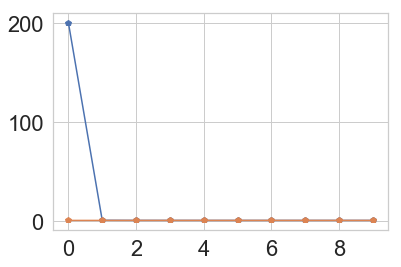

In [287]:
plt.plot(model.history.history['loss'],'-p')
plt.plot(model.history.history['val_loss'],'-p')


In [288]:
model.predict(train_x_).ravel()

array([0.01156774, 0.01156774, 0.01156774, ..., 0.01156774, 0.01156774,
       0.01156774], dtype=float32)

In [290]:
del train_1, valid_1, train_test_X, train_x_, valid_x_, embedding_matrix
del new_df, w2v_model, tokenizer
gc.collect()

0

In [11]:
import h2o
h2o.init()


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_121"; OpenJDK Runtime Environment (Zulu 8.20.0.5-linux64) (build 1.8.0_121-b15); OpenJDK 64-Bit Server VM (Zulu 8.20.0.5-linux64) (build 25.121-b15, mixed mode)
  Starting server from /home/ankish/anaconda3/h2o_jar/h2o.jar
  Ice root: /tmp/tmpk4b_xv35
  JVM stdout: /tmp/tmpk4b_xv35/h2o_ankish_started_from_python.out
  JVM stderr: /tmp/tmpk4b_xv35/h2o_ankish_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,03 secs
H2O cluster timezone:,Asia/Kolkata
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.2
H2O cluster version age:,"1 year, 1 month and 28 days !!!"
H2O cluster name:,H2O_from_python_ankish_bz2ak0
H2O cluster total nodes:,1
H2O cluster free memory:,2.590 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


In [35]:
# train1 = train_.astype('object')
# valid1 = valid_.astype('object')


In [38]:
train = h2o.H2OFrame(pd.concat([train1, y_tr], axis=1))                     
test  = h2o.H2OFrame(pd.concat([valid1, y_val], axis=1))                     

print(train.shape, test.shape)

x = list(train_.columns)
y = "amount_spent_per_room_night_scaled"

gc.collect()

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
(256068, 58) (85356, 58)


0

In [13]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator

In [30]:
gbm_params = {
#     'nfolds'              :  3,
#     'ignored_columns'     : drop_cols,
    'ntrees'              : 200,
    'max_depth'           : 4,# (default=20)
    'min_rows'            : None, # Specify the minimum number of observations for a leaf
    'nbins'               :  63, # Specify the number of bins for the histogram to build, then split at the best point.
#     'nbins_cats'          : None # (Extensively tuning needed)
#     'verbose'             : True,
    'seed'                : 1234,
    'learn_rate'          : 0.01,
#     'learn_rate_annealing': 0.99, # (danger as it reduce the lr_rate rapidly) (for lr:0.01, use lr:0.05, with anealing of 0.99, lead to better converger (fast))
    'distribution'        :'gaussian', # Classification: binomial(binary), quasibinomial(binary), multinomial(Categorical) and for numeric: poisson, laplace, tweedie, gaussian, huber, gamma, quantile
    'sample_rate'         : 0.7, # default 0.63 (samples without replacement)
#     'sample_rate_per_class':0.7, # sample from the full dataset using a per-class-specific sampling rate rather than a global sample factor
    'col_sample_rate'     : 0.7, # sampling without replacement
#     'col_sample_rate_per_tree':0.7, # sample without replacement.
    'histogram_type'      : 'AUTO', # [AUTO, UniformAdaptive, Random ==> (Extremely Randomized Trees), QuantilesGlobal, RoundRobin]
#     'fold_column'         : None, # col name for cv fold
#     'weights_column'      : col_name, # which should be present in the dataframe as an indiaction to weights of each row.
#     'fold_assignment'     : 'Random', # (used only is fold_column is not specified) [Random, Modulo, Stratified]
#     'balance_classes'     : True, # only for classification (balance the classes by oversampling),

    'min_split_improvement' : 1e-5, # need extensive tuning (the minimum relative improvement in squared error reduction in order for a split to happen. When properly tuned, this option can help reduce overfitting. Optimal values would be in the 1e-10…1e-3 range.)
    'categorical_encoding'  : 'eigen', #[AUTO, enum, enum_limited, one_hot_explicit, binary, eigen, label_encoder, sort_by_response (Reorders the levels by the mean response)]
#     'keep_cross_validation_predictions':True,
    'score_each_iteration'  : True, # scoring at each iteration
    'score_tree_interval'   : 5, # score after each 5 tree built
    'stopping_rounds'       : 25, # wait for n(25) itrs for early stopping
    'stopping_metric'       : 'rmse', # [deviance, logloss, mse, rmse, mae, rmsle, auc, misclassification, mean_per_class_error]
    'stopping_tolerance'    : 0.001, # tolerance factor for wait till stopping
#     'max_after_balance_size': 1,# (0-inf) for oversampling choose > 1, else < 1.
#     'class_sampling_factors': 1, # ration of over/under-sampling rate. By default, these ratios are automatically computed during training to obtain the class balance. Note that this requires balance_classes=true.
#     'quantile_alpha'        : 0.01, # when distribution is quantile. (Specify the quantile to be used for Quantile Regression.)
#     'huber_alpha'           : 0.001, # Huber/M-regression (the threshold between quadratic and linear loss)
#     'max_abs_leafnode_pred' : None, # (only for clf), it reduce overfitting by limiting the maximum absolute value of a leaf node prediction
#     'pred_noise_bandwidth'  : 0 # The bandwidth (sigma) of Gaussian multiplicative noise ~N(1,sigma) for tree node predictions. If this parameter is specified with a value greater than 0, then every leaf node prediction is randomly scaled by a number drawn from a Normal distribution centered around 1 with a bandwidth given by this parameter
#     'nbins_top_level'       : None # Specify the minimum number of bins at the root level to use to build the histogram. This number will then be decreased by a factor of two per level.
}

In [31]:
x = list(train.columns)
y = "amount_spent_per_room_night_scaled"
x.remove(y)

gbm_model = H2OGradientBoostingEstimator(**gbm_params)
gbm_model.train(x, y, training_frame=train, validation_frame=test)
gbm_model.rmse()

gbm Model Build progress: |███████████████████████████████████████████████| 100%


1.009754306062416

In [22]:
# gbm_model.hit_ratio_table(valid=True)

1.0097543060623764

In [ ]:
drf_model_deep = H2ORandomForestEstimator( 
nfolds=3, seed=1234,
keep_cross_validation_predictions=True,
fold_assignment = 'stratified',
histogram_type = 'QuantilesGlobal',
categorical_encoding = 'eigen',
stopping_metric = 'auc',
ntrees = 100,
balance_classes = True
)

def get_drf_details():
    """
    'nfolds': 3,
    'keep_cross_validation_predictions':True,
    'score_each_iteration' : True, # scoring at each iteration
    'score_tree_interval'  : 5, # score after each 5 tree built
    'fold_assignment'      : 'Random', # (used only is fold_column is not specified) [Random, Modulo, Stratified]
    'fold_column'          : None, # col name for cv fold
    'ignored_columns'      : drop_cols,
    'balance_classes'      : True, # only for classification (balance the classes by oversampling),
    'max_after_balance_size':1,# (0-inf) for oversampling choose > 1, else < 1.
    'ntrees'               : 200,
    'max_depth'            : 10,# (default=20)
    'min_rows'             : None, # Specify the minimum number of observations for a leaf
    'nbins'                : 63, # Specify the number of bins for the histogram to build, then split at the best point.
    'nbins_top_level'      : None # Specify the minimum number of bins at the root level to use to build the histogram. This number will then be decreased by a factor of two per level.
    # 'nbins_cats': # (Extensively tuning needed)
    'stopping_rounds'      : 25, # wait for n(25) itrs for early stopping
    'stopping_metric'      : 'auc', # [deviance, logloss, mse, rmse, mae, rmsle, auc, misclassification, mean_per_class_error]
    'stopping_tolerance'   : 0.001, # tolerance factor for wait till stopping
    'seed'                 : 1234,
    'categorical_encoding' : 'AUTO', #[AUTO, enum, enum_limited, one_hot_explicit, binary, eigen, label_encoder, sort_by_response (Reorders the levels by the mean response)]
    'verbose'              : 25,
    'histogram_type'       : 'AUTO', # [AUTO, UniformAdaptive, Random ==> (Extremely Randomized Trees), QuantilesGlobal, RoundRobin]
    'col_sample_rate_per_tree':0.7, # sample without replacement.
    'min_split_improvement': 1e-5, # need extensive tuning (the minimum relative improvement in squared error reduction in order for a split to happen. When properly tuned, this option can help reduce overfitting. Optimal values would be in the 1e-10…1e-3 range.)
    'sample_rate'          : 0.7, # default 0.63 (samples without replacement)
    'sample_rate_per_class': 0.7, # sample from the full dataset using a per-class-specific sampling rate rather than a global sample factor
    'binomial_double_trees': True, # (Binary classification only) Build twice as many trees (one per class). Enabling this option can lead to higher accuracy, while disabling can result in faster model building.
    'mtries'               : -1, # Specify the columns to randomly select at each level. If the default value of -1 is used, the number of variables is the square root of the number of columns for classification and p/3 for regression (where p is the number of predictors). The range is -1 to >=1.
    'class_sampling_factors':1, # ration of over/under-sampling rate. By default, these ratios are automatically computed during training to obtain the class balance. Note that this requires balance_classes=true.
    'weights_column':col_name, # which should be present in the dataframe as an indiaction to weights of each row.
    """
    pass

In [ ]:
gbm_params = {
    'max_depth'           : 4,# (default=20)
    'min_rows'            : None, # Specify the minimum number of observations for a leaf
    'sample_rate'         : 0.7, # default 0.63 (samples without replacement)
    'col_sample_rate'     : 0.7, # sampling without replacement
    
    'ntrees'              : 200,
    'nbins'               :  63, # Specify the number of bins for the histogram to build, then split at the best point.
    'seed'                : 1234,
    'learn_rate'          : 0.01,
    'distribution'        :'gaussian', # Classification: binomial(binary), quasibinomial(binary), multinomial(Categorical) and for numeric: poisson, laplace, tweedie, gaussian, huber, gamma, quantile
    'histogram_type'      : 'AUTO', # [AUTO, UniformAdaptive, Random ==> (Extremely Randomized Trees), QuantilesGlobal, RoundRobin]
    'min_split_improvement' : 1e-5, # need extensive tuning (the minimum relative improvement in squared error reduction in order for a split to happen. When properly tuned, this option can help reduce overfitting. Optimal values would be in the 1e-10…1e-3 range.)
    'categorical_encoding'  : 'AUTO', #[AUTO, enum, enum_limited, one_hot_explicit, binary, eigen, label_encoder, sort_by_response (Reorders the levels by the mean response)]
    'score_each_iteration'  : True, # scoring at each iteration
    'score_tree_interval'   : 5, # score after each 5 tree built
    'stopping_rounds'       : 25, # wait for n(25) itrs for early stopping
    'stopping_metric'       : 'rmse', # [deviance, logloss, mse, rmse, mae, rmsle, auc, misclassification, mean_per_class_error]
    'stopping_tolerance'    : 0.001, # tolerance factor for wait till stopping
}

In [69]:
from bayes_opt import BayesianOptimization

def bayesian_opt_gbm(X_train, X_valid):
        
    def train_gbm_model(min_rows, sample, depth, col_sample, min_split):
     
        params = {}

        params['min_rows']        = max(min_rows, 0.3)        
        params['max_depth']       = int(depth)
        params['sample_rate']     = max(sample, 0.3)
        params['col_sample_rate'] = col_sample
        params['min_split_improvement'] = min_split

        param_const = {
            'ntrees'               : 5000,
            'nbins'                :  63, # Specify the number of bins for the histogram to build, then split at the best point.
            'seed'                 : 1234,
            'learn_rate'           : 0.01,
            'distribution'         :'gaussian', # Classification: binomial(binary), quasibinomial(binary), multinomial(Categorical) and for numeric: poisson, laplace, tweedie, gaussian, huber, gamma, quantile
            'histogram_type'       : 'AUTO', # [AUTO, UniformAdaptive, Random ==> (Extremely Randomized Trees), QuantilesGlobal, RoundRobin]
#             'min_split_improvement': 1e-5, # (1e-10…1e-3) need extensive tuning (the minimum relative improvement in squared error reduction in order for a split to happen. When properly tuned, this option can help reduce overfitting. Optimal values would be in the 1e-10…1e-3 range.)
            'categorical_encoding' : 'AUTO', #[AUTO, enum, enum_limited, one_hot_explicit, binary, eigen, label_encoder, sort_by_response (Reorders the levels by the mean response)]
            'score_each_iteration' : True, # scoring at each iteration
            'score_tree_interval'  : 2, # score after each 5 tree built
            'stopping_rounds'      : 5, # wait for n(25) itrs for early stopping
            'stopping_metric'      : 'rmse', # [deviance, logloss, mse, rmse, mae, rmsle, auc, misclassification, mean_per_class_error]
            'stopping_tolerance'   : 0.01, # tolerance factor for wait till stopping
        }

        for key, item in param_const.items():
            params[key] = item
    
        

        gbm_model = H2OGradientBoostingEstimator(**params)
        gbm_model.train(x, y, training_frame=X_train, validation_frame=X_valid)
        score = gbm_model.rmse()

        return -score

    _bo = BayesianOptimization(train_gbm_model, {

        'min_rows'   : (1,9),
        'sample'     : (0.3,0.8),
        'depth'      : (3,15), # int
        'col_sample' : (0.3,0.8),
        'min_split'  : (1e-9,1e-3),

    }, random_state=23456)
    _bo.maximize(init_points=50, n_iter=40, acq='ei')
    
    return _bo



In [65]:
h2o.no_progress()

In [70]:
bo_tuning_gbm = bayesian_opt_gbm(train, test)


|   iter    |  target   | col_sa... |   depth   | min_rows  | min_split |  sample   |
-------------------------------------------------------------------------------------
|  1        | -1.078    |  0.4609   |  6.928    |  8.419    |  0.000311 |  0.381    |
|  2        | -1.074    |  0.482    |  9.351    |  7.313    |  0.000875 |  0.6183   |
|  3        | -1.069    |  0.7949   |  12.79    |  1.33     |  0.000202 |  0.3762   |
|  4        | -1.075    |  0.6765   |  8.462    |  8.637    |  0.000937 |  0.3677   |
|  5        | -1.078    |  0.418    |  6.778    |  6.382    |  0.000620 |  0.6111   |
|  6        | -1.072    |  0.7189   |  10.57    |  5.488    |  0.000986 |  0.6416   |
|  7        | -1.067    |  0.3507   |  14.28    |  6.211    |  0.000227 |  0.5159   |
|  8        | -1.068    |  0.495    |  12.07    |  2.141    |  9.862e-0 |  0.7189   |
|  9        | -1.08     |  0.3544   |  5.991    |  4.807    |  0.000883 |  0.3887   |
|  10       | -1.082    |  0.693    |  3.421    |  5.8

In [71]:
from bayes_opt import BayesianOptimization

def bayesian_opt_drf(X_train, X_valid):
        
    def train_drf_model(min_rows, sample, depth, col_sample, min_split):
     
        params = {}

        params['min_rows']        = max(min_rows, 0.3)        
        params['max_depth']       = int(depth)
        params['sample_rate']     = max(sample, 0.3)
        params['min_split_improvement']   = min_split
        params['col_sample_rate_per_tree'] = col_sample

        param_const = {
            'ntrees'               : 400,
            'score_each_iteration' : True, # scoring at each iteration
            'score_tree_interval'  : 5, # score after each 5 tree built
#             'nbins'                : 63, # Specify the number of bins for the histogram to build, then split at the best point.
            'stopping_rounds'      : 2, # wait for n(25) itrs for early stopping
            'stopping_metric'      : 'rmse', # [deviance, logloss, mse, rmse, mae, rmsle, auc, misclassification, mean_per_class_error]
            'stopping_tolerance'   : 0.01, # tolerance factor for wait till stopping
            'seed'                 : 1234,
            'categorical_encoding' : 'AUTO', #[AUTO, enum, enum_limited, one_hot_explicit, binary, eigen, label_encoder, sort_by_response (Reorders the levels by the mean response)]
            'histogram_type'       : 'AUTO', # [AUTO, UniformAdaptive, Random ==> (Extremely Randomized Trees), QuantilesGlobal, RoundRobin]
        }

        for key, item in param_const.items():
            params[key] = item
    
        

        model = H2ORandomForestEstimator(**params)
        model.train(x, y, training_frame=X_train, validation_frame=X_valid)
        score = model.rmse()

        return -score

    _bo = BayesianOptimization(train_drf_model, {

        'min_rows'   : (1,9),
        'sample'     : (0.3,0.8),
        'depth'      : (3,15), # int
        'col_sample' : (0.3,0.8),
        'min_split'  : (1e-8,1e-3),

    }, random_state=23456)
    _bo.maximize(init_points=50, n_iter=40, acq='ei')
    
    return _bo



In [72]:
bo_tuning_drf = bayesian_opt_drf(train, test)


|   iter    |  target   | col_sa... |   depth   | min_rows  | min_split |  sample   |
-------------------------------------------------------------------------------------
|  1        | -1.016    |  0.4609   |  6.928    |  8.419    |  0.000311 |  0.381    |
|  2        | -1.01     |  0.482    |  9.351    |  7.313    |  0.000875 |  0.6183   |
|  3        | -1.012    |  0.7949   |  12.79    |  1.33     |  0.000202 |  0.3762   |
|  4        | -1.008    |  0.6765   |  8.462    |  8.637    |  0.000937 |  0.3677   |
|  5        | -1.021    |  0.418    |  6.778    |  6.382    |  0.000620 |  0.6111   |
|  6        | -1.008    |  0.7189   |  10.57    |  5.488    |  0.000986 |  0.6416   |
|  7        | -1.017    |  0.3507   |  14.28    |  6.211    |  0.000227 |  0.5159   |
|  8        | -1.021    |  0.495    |  12.07    |  2.141    |  9.871e-0 |  0.7189   |
|  9        | -1.024    |  0.3544   |  5.991    |  4.807    |  0.000883 |  0.3887   |
|  10       | -1.051    |  0.693    |  3.421    |  5.8

In [73]:
bo_tuning_gbm.max, bo_tuning_drf.max

({'target': -1.0599026936288272,
  'params': {'col_sample': 0.7242822312930688,
   'depth': 14.993440885191694,
   'min_rows': 1.6443264205577606,
   'min_split': 0.0008642254019696913,
   'sample': 0.7990592980041672}},
 {'target': -1.0019219750991446,
  'params': {'col_sample': 0.774610595517792,
   'depth': 11.779096559106708,
   'min_rows': 8.07895045786083,
   'min_split': 0.0009420702334867748,
   'sample': 0.30006254152724415}})

In [74]:
from bayes_opt import BayesianOptimization

def bayesian_opt_gbm(X_train, X_valid):
        
    def train_gbm_model(min_rows, sample, depth, col_sample, min_split):
     
        params = {}

        params['min_rows']        = max(min_rows, 0.3)        
        params['max_depth']       = int(depth)
        params['sample_rate']     = max(sample, 0.3)
        params['col_sample_rate'] = col_sample
        params['min_split_improvement'] = min_split

        param_const = {
            'ntrees'               : 5000,
            'nbins'                :  63, # Specify the number of bins for the histogram to build, then split at the best point.
            'seed'                 : 1234,
            'learn_rate'           : 0.01,
            'distribution'         :'gaussian', # Classification: binomial(binary), quasibinomial(binary), multinomial(Categorical) and for numeric: poisson, laplace, tweedie, gaussian, huber, gamma, quantile
            'histogram_type'       : 'AUTO', # [AUTO, UniformAdaptive, Random ==> (Extremely Randomized Trees), QuantilesGlobal, RoundRobin]
#             'min_split_improvement': 1e-5, # (1e-10…1e-3) need extensive tuning (the minimum relative improvement in squared error reduction in order for a split to happen. When properly tuned, this option can help reduce overfitting. Optimal values would be in the 1e-10…1e-3 range.)
            'categorical_encoding' : 'sort_by_response', #[AUTO, enum, enum_limited, one_hot_explicit, binary, eigen, label_encoder, sort_by_response (Reorders the levels by the mean response)]
            'score_each_iteration' : True, # scoring at each iteration
            'score_tree_interval'  : 2, # score after each 5 tree built
            'stopping_rounds'      : 5, # wait for n(25) itrs for early stopping
            'stopping_metric'      : 'rmse', # [deviance, logloss, mse, rmse, mae, rmsle, auc, misclassification, mean_per_class_error]
            'stopping_tolerance'   : 0.01, # tolerance factor for wait till stopping
        }

        for key, item in param_const.items():
            params[key] = item
    
        

        gbm_model = H2OGradientBoostingEstimator(**params)
        gbm_model.train(x, y, training_frame=X_train, validation_frame=X_valid)
        score = gbm_model.rmse()

        return -score

    _bo = BayesianOptimization(train_gbm_model, {

        'min_rows'   : (1,9),
        'sample'     : (0.3,0.8),
        'depth'      : (3,15), # int
        'col_sample' : (0.3,0.8),
        'min_split'  : (1e-9,1e-3),

    }, random_state=23456)
    _bo.maximize(init_points=50, n_iter=40, acq='ei')
    
    return _bo



In [75]:
# try:
#     bo_tuning_gbm2 = bayesian_opt_gbm(train, test)
# except:
#     print("failed")
bo_tuning_gbm2 = bayesian_opt_gbm(train, test)

|   iter    |  target   | col_sa... |   depth   | min_rows  | min_split |  sample   |
-------------------------------------------------------------------------------------
|  1        | -1.078    |  0.4609   |  6.928    |  8.419    |  0.000311 |  0.381    |
|  2        | -1.074    |  0.482    |  9.351    |  7.313    |  0.000875 |  0.6183   |
|  3        | -1.069    |  0.7949   |  12.79    |  1.33     |  0.000202 |  0.3762   |
|  4        | -1.075    |  0.6765   |  8.462    |  8.637    |  0.000937 |  0.3677   |
|  5        | -1.078    |  0.418    |  6.778    |  6.382    |  0.000620 |  0.6111   |
|  6        | -1.072    |  0.7189   |  10.57    |  5.488    |  0.000986 |  0.6416   |
|  7        | -1.067    |  0.3507   |  14.28    |  6.211    |  0.000227 |  0.5159   |
|  8        | -1.068    |  0.495    |  12.07    |  2.141    |  9.862e-0 |  0.7189   |
|  9        | -1.08     |  0.3544   |  5.991    |  4.807    |  0.000883 |  0.3887   |
|  10       | -1.082    |  0.693    |  3.421    |  5.8

In [76]:
from bayes_opt import BayesianOptimization

def bayesian_opt_drf(X_train, X_valid):
        
    def train_drf_model(min_rows, sample, depth, col_sample, min_split):
     
        params = {}

        params['min_rows']        = max(min_rows, 0.3)        
        params['max_depth']       = int(depth)
        params['sample_rate']     = max(sample, 0.3)
        params['min_split_improvement']   = min_split
        params['col_sample_rate_per_tree'] = col_sample

        param_const = {
            'ntrees'               : 400,
            'score_each_iteration' : True, # scoring at each iteration
            'score_tree_interval'  : 5, # score after each 5 tree built
#             'nbins'                : 63, # Specify the number of bins for the histogram to build, then split at the best point.
            'stopping_rounds'      : 2, # wait for n(25) itrs for early stopping
            'stopping_metric'      : 'rmse', # [deviance, logloss, mse, rmse, mae, rmsle, auc, misclassification, mean_per_class_error]
            'stopping_tolerance'   : 0.01, # tolerance factor for wait till stopping
            'seed'                 : 1234,
            'categorical_encoding' : 'sort_by_response', #[AUTO, enum, enum_limited, one_hot_explicit, binary, eigen, label_encoder, sort_by_response (Reorders the levels by the mean response)]
            'histogram_type'       : 'AUTO', # [AUTO, UniformAdaptive, Random ==> (Extremely Randomized Trees), QuantilesGlobal, RoundRobin]
        }

        for key, item in param_const.items():
            params[key] = item
    
        

        model = H2ORandomForestEstimator(**params)
        model.train(x, y, training_frame=X_train, validation_frame=X_valid)
        score = model.rmse()

        return -score

    _bo = BayesianOptimization(train_drf_model, {

        'min_rows'   : (1,9),
        'sample'     : (0.3,0.8),
        'depth'      : (3,15), # int
        'col_sample' : (0.3,0.8),
        'min_split'  : (1e-8,1e-3),

    }, random_state=23456)
    _bo.maximize(init_points=50, n_iter=40, acq='ei')
    
    return _bo



In [77]:
# try:
#     bo_tuning_drf2 = bayesian_opt_drf(train, test)
# except:
#     print("failed")
bo_tuning_drf2 = bayesian_opt_drf(train, test)

|   iter    |  target   | col_sa... |   depth   | min_rows  | min_split |  sample   |
-------------------------------------------------------------------------------------
|  1        | -1.016    |  0.4609   |  6.928    |  8.419    |  0.000311 |  0.381    |
|  2        | -1.01     |  0.482    |  9.351    |  7.313    |  0.000875 |  0.6183   |
|  3        | -1.012    |  0.7949   |  12.79    |  1.33     |  0.000202 |  0.3762   |
|  4        | -1.008    |  0.6765   |  8.462    |  8.637    |  0.000937 |  0.3677   |
|  5        | -1.021    |  0.418    |  6.778    |  6.382    |  0.000620 |  0.6111   |
|  6        | -1.008    |  0.7189   |  10.57    |  5.488    |  0.000986 |  0.6416   |
|  7        | -1.017    |  0.3507   |  14.28    |  6.211    |  0.000227 |  0.5159   |
|  8        | -1.021    |  0.495    |  12.07    |  2.141    |  9.871e-0 |  0.7189   |
|  9        | -1.024    |  0.3544   |  5.991    |  4.807    |  0.000883 |  0.3887   |
|  10       | -1.051    |  0.693    |  3.421    |  5.8

In [78]:
bo_tuning_gbm2.max, bo_tuning_drf2.max

({'target': -1.0599026936288272,
  'params': {'col_sample': 0.7242822312930688,
   'depth': 14.993440885191694,
   'min_rows': 1.6443264205577606,
   'min_split': 0.0008642254019696913,
   'sample': 0.7990592980041672}},
 {'target': -1.0019219750991446,
  'params': {'col_sample': 0.774610595517792,
   'depth': 11.779096559106708,
   'min_rows': 8.07895045786083,
   'min_split': 0.0009420702334867748,
   'sample': 0.30006254152724415}})

In [79]:
h2o.shutdown(prompt=False)

[WARNING] in <ipython-input-79-02ff3806b010> line 1:
    >>> h2o.shutdown(prompt=False)
        ^^^^ Deprecated, use ``h2o.cluster().shutdown()``.
H2O session _sid_934b closed.


In [117]:
cols_to_drop= ['res_staResidence_median','tr_flag','reservationstatusid_code',
               'res_resortType_median','res_stResort_median','res_cluster_median']
train_.drop(cols_to_drop, axis=1, inplace=True)
valid_.drop(cols_to_drop, axis=1, inplace=True)


In [129]:
from catboost import Pool, CatBoostClassifier, CatBoostRegressor
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization

def bayesian_opt_cat(X_train, y_train, X_valid, y_valid, features):
        
    def train_cat_model(r_str, b_temp, l2, depth):
    
        params = {}

        params['random_strength']     = max(min(r_str, 1), 0)
        params['bagging_temperature'] = max(b_temp, 0)
        
        params['l2_leaf_reg'] = max(l2, 0)
#         params['min_data_in_leaf'] = max(data_leaf,1)
        
#         params['subsample'] = subsample
        params['depth']     = int(depth)

        param_const = {
            'border_count'          : 63,
            'early_stopping_rounds' : 50,
            'random_seed'           : 1337,
            'task_type'             : 'CPU', 
            'loss_function'         : "RMSE", 
    #         'subsample'             = 0.7, 
            'iterations'            : 10000, 
            'learning_rate'         : 0.01,
            'thread_count'          : 4,
#             'bootstrap_type'        : 'No'
        }

        for key, item in param_const.items():
            params[key] = item
    
        

        _train = Pool(X_train[features], label=y_train)#, cat_features=cate_features_index)
        _valid = Pool(X_valid[features], label=y_valid)#, cat_features=cate_features_index)

        watchlist = [_train, _valid]
        clf = CatBoostRegressor(**params)
        clf.fit(_train, 
                eval_set=watchlist, 
                verbose=0,
                use_best_model=True)

        oof  = clf.predict(X_valid[features])

        score = mean_squared_error(y_valid, oof)

        return -score

    _bo = BayesianOptimization(train_cat_model, {

        'r_str'      : (1, 5),
        'b_temp'     : (0.01, 100),
        'depth'      : (3,8), # int
#         'subsample'  : (0.3, 0.8),
#         'data_leaf'  : (2,7),
        'l2'         : (0, 5),

    }, random_state=23456)
    _bo.maximize(init_points=40, n_iter=10, acq='ei')
    
    return _bo



In [130]:
bo_tuning_cat = bayesian_opt_cat(train_, y_tr, valid_, y_val, list(train_.columns))


|   iter    |  target   |  b_temp   |   depth   |    l2     |   r_str   |
-------------------------------------------------------------------------
|  1        | -0.9557   |  32.19    |  4.637    |  4.637    |  2.247    |
|  2        | -0.9541   |  16.2     |  4.82     |  2.646    |  4.156    |
|  3        | -1.183    |  87.54    |  6.183    |  4.949    |  4.264    |
|  4        | -0.9495   |  4.141    |  4.015    |  0.762    |  4.012    |
|  5        | -1.183    |  45.52    |  7.773    |  4.687    |  1.542    |
|  6        | -0.955    |  23.6     |  4.574    |  3.363    |  3.482    |
|  7        | -1.183    |  62.22    |  7.189    |  3.154    |  3.244    |
|  8        | -1.183    |  98.69    |  6.416    |  0.5066   |  4.76     |
|  9        | -1.183    |  65.14    |  4.137    |  2.159    |  2.56     |
|  10       | -1.183    |  75.58    |  3.713    |  0.04931  |  4.352    |
|  11       | -0.9538   |  10.89    |  4.246    |  2.379    |  4.536    |
|  12       | -0.9467   |  17.76    | 

In [131]:
bo_tuning_cat.max

{'target': -0.936643244977595,
 'params': {'b_temp': 0.2723396850738524,
  'depth': 7.510674689759464,
  'l2': 0.13891935633855657,
  'r_str': 1.310147030542665}}

In [132]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from bayes_opt import BayesianOptimization

def bayesian_opt_lgb(X_train, y_train, X_valid, y_valid, features):
        
    def train_lgb_model(f_frac, b_frac, 
                        l1, l2, split_gain,
                        leaves, data_in_leaf, hessian):
    
        param = {}

        param['feature_fraction'] = max(min(f_frac, 1), 0)
        param['bagging_fraction'] = max(min(b_frac, 1), 0)

        param['lambda_l1'] = max(l1, 0)
        param['lambda_l2'] = max(l2, 0)
        param['min_split_gain'] = split_gain
#     #     params['min_child_weight'] = min_child_weight

        param['num_leaves'] = int(leaves)
        param['min_data_in_leaf'] = int(data_in_leaf)
        param['min_sum_hessian_in_leaf'] = max(hessian, 0)

        param_const = {
            'max_bins'               : 63,
            'learning_rate'          : 0.01,
            'num_threads'            : 4,
            'metric'                 : 'rmse',
            'boost'                  : 'gbdt',
            'tree_learner'           : 'serial',
            'objective'              : 'root_mean_squared_error',
            'verbosity'              : 0,
        }

        for key, item in param_const.items():
            param[key] = item
    
#         print(param)

        _train = lgb.Dataset(X_train[features], label=y_train, feature_name=list(features))
        _valid = lgb.Dataset(X_valid[features], label=y_valid,feature_name=list(features))

        clf = lgb.train(param, _train, 10000, 
                        valid_sets = [_train, _valid], 
                        verbose_eval=0, 
                        early_stopping_rounds = 25)                  

        oof = clf.predict(X_valid[features], num_iteration=clf.best_iteration)
        score = mean_squared_error(y_valid, oof)

        return -score


    _bo = BayesianOptimization(train_lgb_model, {
 
        'b_frac'       : (0.35, 0.7),
        'f_frac'       : (0.35, 0.8),
        'leaves'       : (40,90), # int
        'split_gain'   : (0, 2),
        'l1'           : (0, 3),
        'l2'           : (0, 3),
        'data_in_leaf' : (20, 1000), # int
        'hessian'      : (0, 20),


    }, random_state=23456)
    _bo.maximize(init_points=40, n_iter=10, acq='ei')
    
    return _bo



In [133]:
bo_tuning_lgb = bayesian_opt_lgb(train_, y_tr, valid_, y_val, list(train_.columns))


|   iter    |  target   |  b_frac   | data_i... |  f_frac   |  hessian  |    l1     |    l2     |  leaves   | split_... |
-------------------------------------------------------------------------------------------------------------------------
|  1        | -0.9384   |  0.4626   |  340.8    |  0.7673   |  6.234    |  0.4859   |  1.092    |  66.46    |  1.578    |
|  2        | -0.9386   |  0.6564   |  643.9    |  0.7954   |  16.32    |  0.1239   |  0.6088   |  47.62    |  1.506    |
|  3        | -0.9383   |  0.5093   |  955.5    |  0.7718   |  2.708    |  0.7077   |  0.9445   |  73.63    |  1.241    |
|  4        | -0.9394   |  0.5677   |  841.1    |  0.6339   |  11.22    |  2.961    |  2.049    |  45.07    |  1.88     |
|  5        | -0.9387   |  0.578    |  242.9    |  0.5443   |  7.802    |  2.267    |  0.4279   |  40.49    |  1.676    |
|  6        | -0.9379   |  0.3881   |  264.2    |  0.5642   |  17.68    |  0.5325   |  2.358    |  41.75    |  1.217    |
|  7        | -0.9368   

In [134]:
bo_tuning_lgb.max

{'target': -0.9366038416699407,
 'params': {'b_frac': 0.39937875430495523,
  'data_in_leaf': 963.4474670540025,
  'f_frac': 0.5843695475428001,
  'hessian': 18.65591873327566,
  'l1': 0.7023140275136406,
  'l2': 1.176454958110745,
  'leaves': 68.04330156497795,
  'split_gain': 0.36860443684254807}}

In [ ]:
{'target': -0.9362267064104927,
 'params': {'b_frac': 0.3677516358370858,
  'data_in_leaf': 495.44417416221626,
  'f_frac': 0.5422060360159515,
  'hessian': 5.039378213231793,
  'l1': 1.0642598045225304,
  'l2': 2.564544963055539,
  'leaves': 89.62655396835916,
  'split_gain': 0.16542750189034394}}

bo_tuning_cat.max

{'target': -0.9366723276780314,
 'params': {'b_temp': 0.08307474720468191,
  'depth': 7.596402546589758,
  'l2': 3.9791105400066655,
  'r_str': 1.1206250787323229}}

In [ ]:
train_.tr_flag

In [112]:
cols_ = [
'res_resortType_median',
'cluster_code',
'res_stResort_median',
'res_staResidence_count',
'checkin_month',
'channel_code',
'res_cluster_median',
'numberofchildren',
'member_age_buckets',
'dayDiff_staResidence_count',
'booking_type_code',
'reservationstatusid_code',
'booking_week',
'booking_month',
'booking_dow',
'checkin_dow',
'mem_resortRegion_count',
'mem_staResidence_count',
'res_staResidence_median']
train_[cols_].apply(lambda x: pd.Series.value_counts(x).shape[0])

mem_staResidence_max           42
room_type_booked_code           6
res_staResidence_max           47
mem_resortRegion_max           41
mem_resortType_max             41
res_resortType_median           3
cluster_code                    6
res_stResort_median             3
res_staResidence_count        424
checkin_month                  12
channel_code                    3
res_cluster_median              3
numberofchildren               11
member_age_buckets             10
dayDiff_staResidence_count    179
booking_type_code               2
reservationstatusid_code        4
booking_week                   53
booking_month                  12
booking_dow                     7
checkin_dow                     7
mem_resortRegion_count         26
mem_staResidence_count         36
res_staResidence_median        16
dtype: int64

In [135]:
cols_ = [
'res_resortType_median',
'cluster_code',
'res_stResort_median',
'res_staResidence_count',
'checkin_month',
'channel_code',
'res_cluster_median',
'numberofchildren',
'member_age_buckets',
'dayDiff_staResidence_count',
'booking_type_code',
'reservationstatusid_code',
'booking_week',
'booking_month',
'booking_dow',
'checkin_dow',
'mem_resortRegion_count',
'mem_staResidence_count',
'res_staResidence_median']
keep_cols = set(train_.columns) - set(cols_)
train_ = train_[list(keep_cols)]
valid_ = valid_[list(keep_cols)]

# train_.drop(cols_, axis=1, inplace=True)
# valid_.drop(cols_, axis=1, inplace=True)


In [136]:

import h2o
h2o.init()

train = h2o.H2OFrame(pd.concat([train_, y_tr], axis=1))                     
test  = h2o.H2OFrame(pd.concat([valid_, y_val], axis=1))                     

print(train.shape, test.shape)

x = list(train_.columns)
y = "amount_spent_per_room_night_scaled"

# h2o.shutdown(prompt=False)
gc.collect()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_121"; OpenJDK Runtime Environment (Zulu 8.20.0.5-linux64) (build 1.8.0_121-b15); OpenJDK 64-Bit Server VM (Zulu 8.20.0.5-linux64) (build 25.121-b15, mixed mode)
  Starting server from /home/ankish/anaconda3/h2o_jar/h2o.jar
  Ice root: /tmp/tmpzb2taxpw
  JVM stdout: /tmp/tmpzb2taxpw/h2o_ankish_started_from_python.out
  JVM stderr: /tmp/tmpzb2taxpw/h2o_ankish_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,02 secs
H2O cluster timezone:,Asia/Kolkata
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.2
H2O cluster version age:,"1 year, 1 month and 29 days !!!"
H2O cluster name:,H2O_from_python_ankish_sop7e8
H2O cluster total nodes:,1
H2O cluster free memory:,2.590 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"accepting new members, healthy"


(256068, 38) (85356, 38)


0

In [137]:
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator


In [138]:
from bayes_opt import BayesianOptimization

def bayesian_opt_gbm(X_train, X_valid):
        
    def train_gbm_model(min_rows, sample, depth, col_sample, min_split):
     
        params = {}

        params['min_rows']        = max(min_rows, 0.3)        
        params['max_depth']       = int(depth)
        params['sample_rate']     = max(sample, 0.3)
        params['col_sample_rate'] = col_sample
        params['min_split_improvement'] = min_split

        param_const = {
            'ntrees'               : 5000,
#             'nbins'                :  63, # Specify the number of bins for the histogram to build, then split at the best point.
            'seed'                 : 1234,
            'learn_rate'           : 0.01,
            'distribution'         :'gaussian', # Classification: binomial(binary), quasibinomial(binary), multinomial(Categorical) and for numeric: poisson, laplace, tweedie, gaussian, huber, gamma, quantile
            'histogram_type'       : 'AUTO', # [AUTO, UniformAdaptive, Random ==> (Extremely Randomized Trees), QuantilesGlobal, RoundRobin]
#             'min_split_improvement': 1e-5, # (1e-10…1e-3) need extensive tuning (the minimum relative improvement in squared error reduction in order for a split to happen. When properly tuned, this option can help reduce overfitting. Optimal values would be in the 1e-10…1e-3 range.)
            'categorical_encoding' : 'one_hot_explicit', #[AUTO, enum, enum_limited, one_hot_explicit, binary, eigen, label_encoder, sort_by_response (Reorders the levels by the mean response)]
            'score_each_iteration' : True, # scoring at each iteration
            'score_tree_interval'  : 2, # score after each 5 tree built
            'stopping_rounds'      : 5, # wait for n(25) itrs for early stopping
            'stopping_metric'      : 'rmse', # [deviance, logloss, mse, rmse, mae, rmsle, auc, misclassification, mean_per_class_error]
            'stopping_tolerance'   : 0.01, # tolerance factor for wait till stopping
        }

        for key, item in param_const.items():
            params[key] = item
    
        

        gbm_model = H2OGradientBoostingEstimator(**params)
        gbm_model.train(x, y, training_frame=X_train, validation_frame=X_valid)
        score = gbm_model.rmse()

        return -score

    _bo = BayesianOptimization(train_gbm_model, {

        'min_rows'   : (1,9),
        'sample'     : (0.3,0.8),
        'depth'      : (3,15), # int
        'col_sample' : (0.3,0.8),
        'min_split'  : (1e-9,1e-3),

    }, random_state=23456)
    _bo.maximize(init_points=50, n_iter=10, acq='ei')
    
    return _bo



In [139]:
from bayes_opt import BayesianOptimization

def bayesian_opt_drf(X_train, X_valid):
        
    def train_drf_model(min_rows, sample, depth, col_sample, min_split):
     
        params = {}

        params['min_rows']        = max(min_rows, 0.3)        
        params['max_depth']       = int(depth)
        params['sample_rate']     = max(sample, 0.3)
        params['min_split_improvement']   = min_split
        params['col_sample_rate_per_tree'] = col_sample

        param_const = {
            'ntrees'               : 400,
            'score_each_iteration' : True, # scoring at each iteration
            'score_tree_interval'  : 5, # score after each 5 tree built
#             'nbins'                : 63, # Specify the number of bins for the histogram to build, then split at the best point.
            'stopping_rounds'      : 2, # wait for n(25) itrs for early stopping
            'stopping_metric'      : 'rmse', # [deviance, logloss, mse, rmse, mae, rmsle, auc, misclassification, mean_per_class_error]
            'stopping_tolerance'   : 0.01, # tolerance factor for wait till stopping
            'seed'                 : 1234,
            'categorical_encoding' : 'one_hot_explicit', #[AUTO, enum, enum_limited, one_hot_explicit, binary, eigen, label_encoder, sort_by_response (Reorders the levels by the mean response)]
            'histogram_type'       : 'AUTO', # [AUTO, UniformAdaptive, Random ==> (Extremely Randomized Trees), QuantilesGlobal, RoundRobin]
        }

        for key, item in param_const.items():
            params[key] = item
    
        

        model = H2ORandomForestEstimator(**params)
        model.train(x, y, training_frame=X_train, validation_frame=X_valid)
        score = model.rmse()

        return -score

    _bo = BayesianOptimization(train_drf_model, {

        'min_rows'   : (1,9),
        'sample'     : (0.3,0.8),
        'depth'      : (3,15), # int
        'col_sample' : (0.3,0.8),
        'min_split'  : (1e-8,1e-3),

    }, random_state=23456)
    _bo.maximize(init_points=50, n_iter=10, acq='ei')
    
    return _bo



In [140]:
bo_tuning_gbm3 = bayesian_opt_gbm(train, test)

|   iter    |  target   | col_sa... |   depth   | min_rows  | min_split |  sample   |
-------------------------------------------------------------------------------------
|  1        | -1.078    |  0.4609   |  6.928    |  8.419    |  0.000311 |  0.381    |
|  2        | -1.075    |  0.482    |  9.351    |  7.313    |  0.000875 |  0.6183   |
|  3        | -1.07     |  0.7949   |  12.79    |  1.33     |  0.000202 |  0.3762   |
|  4        | -1.076    |  0.6765   |  8.462    |  8.637    |  0.000937 |  0.3677   |
|  5        | -1.078    |  0.418    |  6.778    |  6.382    |  0.000620 |  0.6111   |
|  6        | -1.073    |  0.7189   |  10.57    |  5.488    |  0.000986 |  0.6416   |
|  7        | -1.068    |  0.3507   |  14.28    |  6.211    |  0.000227 |  0.5159   |
|  8        | -1.069    |  0.495    |  12.07    |  2.141    |  9.862e-0 |  0.7189   |
|  9        | -1.08     |  0.3544   |  5.991    |  4.807    |  0.000883 |  0.3887   |
|  10       | -1.082    |  0.693    |  3.421    |  5.8

In [141]:
bo_tuning_gbm3.max

{'target': -1.061473777541739,
 'params': {'col_sample': 0.7884930582277562,
  'depth': 14.94787819541455,
  'min_rows': 1.8042974412100277,
  'min_split': 0.0009066287511816911,
  'sample': 0.7889619726100149}}

In [142]:
bo_tuning_drf3 = bayesian_opt_drf(train, test)

|   iter    |  target   | col_sa... |   depth   | min_rows  | min_split |  sample   |
-------------------------------------------------------------------------------------
|  1        | -1.02     |  0.4609   |  6.928    |  8.419    |  0.000311 |  0.381    |
|  2        | -1.01     |  0.482    |  9.351    |  7.313    |  0.000875 |  0.6183   |
|  3        | -1.008    |  0.7949   |  12.79    |  1.33     |  0.000202 |  0.3762   |
|  4        | -1.006    |  0.6765   |  8.462    |  8.637    |  0.000937 |  0.3677   |
|  5        | -1.024    |  0.418    |  6.778    |  6.382    |  0.000620 |  0.6111   |
|  6        | -1.007    |  0.7189   |  10.57    |  5.488    |  0.000986 |  0.6416   |
|  7        | -1.014    |  0.3507   |  14.28    |  6.211    |  0.000227 |  0.5159   |
|  8        | -1.019    |  0.495    |  12.07    |  2.141    |  9.871e-0 |  0.7189   |
|  9        | -1.029    |  0.3544   |  5.991    |  4.807    |  0.000883 |  0.3887   |
|  10       | -1.051    |  0.693    |  3.421    |  5.8

In [143]:
bo_tuning_drf3.max

{'target': -1.0025418079767172,
 'params': {'col_sample': 0.7255789313320188,
  'depth': 13.317629140441177,
  'min_rows': 8.978722789164985,
  'min_split': 9.704993612110798e-05,
  'sample': 0.30192767212433214}}

In [144]:
gc.collect()

2349

In [49]:

import pandas as pd
import numpy as np
import os, gc
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import roc_auc_score, mean_squared_error
from catboost import Pool, CatBoostClassifier, CatBoostRegressor
import lightgbm as lgb
import xgboost as xgb


def train_lgb_model(X_train, y_train, X_valid, y_valid, features, param, X_test, num_round):
    """
    Args:
        X_train, X_valid: training and valid data
        y_train, y_valid: training and valid target
        X_test: test-data
        features: training features
    Return:
        oof-pred, test_preds model, model_imp
    """
    _train = lgb.Dataset(X_train[features], label=y_train, feature_name=list(features))
    _valid = lgb.Dataset(X_valid[features], label=y_valid,feature_name=list(features))
    
    clf = lgb.train(param, _train, num_round, 
                    valid_sets = [_train, _valid], 
                    verbose_eval=200, 
                    early_stopping_rounds = 25)                  
    
    oof = clf.predict(X_valid[features], num_iteration=clf.best_iteration)
    test_pred = clf.predict(X_test[features], num_iteration=clf.best_iteration)
    
    lgb_imp = pd.DataFrame(data=[clf.feature_name(), list(clf.feature_importance())]).T
    lgb_imp.columns = ['feature','imp']
    
    return oof, test_pred, clf, lgb_imp
    



def run_cv_lgb(train_df, target, test_df, leaves=None):

    param = {
        'bagging_freq'           : 5,
        'bagging_fraction'       : 0.33,
        'boost_from_average'     : 'false',
        'boost'                  : 'gbdt',
        'feature_fraction'       : 0.3,
        'learning_rate'          : 0.01,
        'max_depth'              : -1,
        'metric'                 : 'rmse',
        'min_data_in_leaf'       : 100,
#         'min_sum_hessian_in_leaf': 10.0,
        'num_leaves'             : 30,
        'num_threads'            : 4,
        'tree_learner'           : 'serial',
        'objective'              : 'root_mean_squared_error',
        'verbosity'              : 1,
    #     'lambda_l1'              : 0.001,
        'lambda_l2'              : 0.1
    }   
    if leaves is not None:
        param['num_leaves'] = leaves
        print("using leaves: ", param['num_leaves'])

    random_seed = 1234
    n_splits = 3
    num_round = 10000
    feature_imp = pd.DataFrame()
    
    folds = KFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    oof_lgb = np.zeros(len(train_df))
    predictions = np.zeros((len(test_df),n_splits))

    clfs = []
    
    for fold_, (train_index, valid_index) in enumerate(folds.split(train_df, target)):
        print(train_index.shape, valid_index.shape)
        print("Fold {}".format(fold_))
    
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
        X_train, X_valid = train_df.iloc[train_index,:], train_df.iloc[valid_index,:]
        features = X_train.columns
        
#         X_train.drop(['disbursal_week','disbursal_day'], axis=1, inplace=True)
#         X_valid.drop(['disbursal_week','disbursal_day'], axis=1, inplace=True)

        num_round = 10000
        oof, test_pred, clf, lgb_imp = train_lgb_model(X_train, y_train, 
                                                       X_valid, y_valid, 
                                                       features, param, 
                                                       test_df, num_round)
        lgb_imp['fold'] = fold_
        feature_imp = pd.concat([feature_imp, lgb_imp], axis=0)
    
        oof_lgb[valid_index] = oof
        predictions[:,fold_] = test_pred
        clfs.append(clf)
        
        score = mean_squared_error(y_valid, oof)
        print( "  rmse = ", 100*np.sqrt(score) )
        print("="*60)
    
    feature_imp.imp = feature_imp.imp.astype('float')
    feature_imp = feature_imp.groupby(['feature'])['imp'].mean()
    feature_imp = pd.DataFrame(data=[feature_imp.index, feature_imp.values]).T
    feature_imp.columns=['feature','imp']
    feature_imp = feature_imp.sort_values(by='imp')

    return clfs, feature_imp, oof_lgb, predictions




In [71]:
import copy

train_df1 = copy.deepcopy(train_df)
test_df1 = copy.deepcopy(test_df)


In [72]:
train_df1.drop(['reservation_id', 'memberid'], axis=1, inplace=True)
test_df1.drop(['reservation_id', 'memberid'], axis=1, inplace=True)

target = train_df.amount_spent_per_room_night_scaled
train_df1.drop('amount_spent_per_room_night_scaled', axis=1, inplace=True)

train_df1 = train_df1.astype('object')
test_df1  = test_df1.astype('object')


In [73]:
complete_df = pd.concat([train_df1, test_df1], axis=0).reset_index(drop=True)

for col in complete_df.columns:
    complete_df[col] = complete_df[col].astype('category').cat.codes
    
del train_df1, test_df1
gc.collect()

train_df1 = complete_df.iloc[:train_df.shape[0]]
test_df1  = complete_df.iloc[train_df.shape[0]:]

gc.collect()

0

In [74]:
clfs_lgb, imp_lgb, oof_lgb, pred_lgb = run_cv_lgb(train_df1, target, 
                                                  test_df1, leaves=50)


using leaves:  50
(227616,) (113808,)
Fold 0
Training until validation scores don't improve for 25 rounds.
[200]	training's rmse: 1.46449	valid_1's rmse: 1.46804
[400]	training's rmse: 1.03143	valid_1's rmse: 1.0345
[600]	training's rmse: 1.0144	valid_1's rmse: 1.01885
[800]	training's rmse: 1.00885	valid_1's rmse: 1.01489
[1000]	training's rmse: 1.00497	valid_1's rmse: 1.01259
[1200]	training's rmse: 1.00098	valid_1's rmse: 1.01027
[1400]	training's rmse: 0.9973	valid_1's rmse: 1.00813
[1600]	training's rmse: 0.992678	valid_1's rmse: 1.00504
[1800]	training's rmse: 0.990019	valid_1's rmse: 1.0038
[2000]	training's rmse: 0.986463	valid_1's rmse: 1.00165
[2200]	training's rmse: 0.984166	valid_1's rmse: 1.00078
[2400]	training's rmse: 0.981085	valid_1's rmse: 0.99911
[2600]	training's rmse: 0.978644	valid_1's rmse: 0.998053
[2800]	training's rmse: 0.97589	valid_1's rmse: 0.996625
[3000]	training's rmse: 0.973695	valid_1's rmse: 0.995726
[3200]	training's rmse: 0.9711	valid_1's rmse: 0.99

In [65]:
from catboost import Pool, CatBoostClassifier, CatBoostRegressor

def train_cat_model(X_train, y_train, X_valid, y_valid, features, param, X_test, 
                    num_round):
    """
    Args:
        X_train, X_valid: training and valid data
        y_train, y_valid: training and valid target
        X_test: test-data
        features: training features
    Return:
        oof-pred, test_preds, model, model_imp
    """
    param['iterations'] = num_round
    
    _train = Pool(X_train[features], label=y_train)#, cat_features=cate_features_index)
    _valid = Pool(X_valid[features], label=y_valid)#, cat_features=cate_features_index)

    watchlist = [_train, _valid]
    clf = CatBoostRegressor(**param)
    clf.fit(_train, 
            eval_set=watchlist, 
            verbose=200,
            use_best_model=True)
        
    oof  = clf.predict(X_valid[features])
    test_pred  = clf.predict(X_test[features])

    cat_imp = pd.DataFrame(data=[clf.feature_names_, 
                                 list(clf.feature_importances_)]).T
    cat_imp.columns = ['feature','imp']
    
    return oof, test_pred, clf, cat_imp


def run_cv_cat(train_df, target, test_df, depth):

    params = {
        'loss_function'         : "RMSE", 
#         'eval_metric'           : "AUC",
        'random_strength'       : 1.5,
        'border_count'          : 128,
#         'scale_pos_weight'      : 3.507,
        'depth'                 : depth, 
        'early_stopping_rounds' : 50,
        'random_seed'           : 1337,
        'task_type'             : 'CPU', 
#         'subsample'             = 0.7, 
        'iterations'            : 10000, 
        'learning_rate'         : 0.09,
        'thread_count'          : 4
    }


    ##########################
    n_splits = 3
    random_seed = 1234
    feature_imp = pd.DataFrame()
    
    folds = KFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    oof_cat = np.zeros(len(train_df))
    predictions = np.zeros((len(test_df),n_splits))
    clfs = []
##########################
    for fold_, (train_index, valid_index) in enumerate(folds.split(train_df, target)):
        print(train_index.shape, valid_index.shape)
        print("Fold {}".format(fold_))
    
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
        X_train, X_valid = train_df.iloc[train_index,:], train_df.iloc[valid_index,:]
        features = X_train.columns
        
        num_rounds = 10000
        oof, test_pred, clf, cat_imp = train_cat_model(X_train, y_train, 
                                                       X_valid, y_valid, 
                                                       features, params, 
                                                       test_df, num_rounds)
    
        oof_cat[valid_index] = oof
        predictions[:,fold_] = test_pred
        
        cat_imp['fold'] = fold_
        feature_imp = pd.concat([feature_imp, cat_imp], axis=0)
        clfs.append(clf)
        
        score = mean_squared_error(y_valid, oof)
        print( "  auc = ", 100*np.sqrt(score) )
        print("="*60)
    
    feature_imp.imp = feature_imp.imp.astype('float')
    feature_imp = feature_imp.groupby(['feature'])['imp'].mean()
    feature_imp = pd.DataFrame(data=[feature_imp.index, feature_imp.values]).T
    feature_imp.columns=['feature','imp']
    feature_imp = feature_imp.sort_values(by='imp')

    return clfs, feature_imp, oof_cat, predictions



In [75]:
clfs_cat, imp_cat, oof_cat, pred_cat = run_cv_cat(train_df1, target, test_df1, 4)


(227616,) (113808,)
Fold 0
0:	learn: 7.1087168	test: 7.1087168	test1: 7.1130523	best: 7.1130523 (0)	total: 20.8ms	remaining: 3m 27s
200:	learn: 1.0182283	test: 1.0182283	test1: 1.0183900	best: 1.0183900 (200)	total: 6.07s	remaining: 4m 56s
400:	learn: 1.0051033	test: 1.0051033	test1: 1.0070166	best: 1.0070166 (400)	total: 12.1s	remaining: 4m 49s
600:	learn: 0.9972679	test: 0.9972679	test1: 1.0008241	best: 1.0008216 (599)	total: 18s	remaining: 4m 41s
800:	learn: 0.9920203	test: 0.9920203	test1: 0.9968622	best: 0.9968622 (800)	total: 23.8s	remaining: 4m 33s
1000:	learn: 0.9881551	test: 0.9881551	test1: 0.9941965	best: 0.9941965 (1000)	total: 29.6s	remaining: 4m 26s
1200:	learn: 0.9847933	test: 0.9847933	test1: 0.9921452	best: 0.9921452 (1200)	total: 35.5s	remaining: 4m 20s
1400:	learn: 0.9824931	test: 0.9824931	test1: 0.9911621	best: 0.9911561 (1399)	total: 41.4s	remaining: 4m 14s
1600:	learn: 0.9803233	test: 0.9803233	test1: 0.9900051	best: 0.9900044 (1599)	total: 47.2s	remaining: 4m 7s

In [85]:

def train_xgb_model(X_train, y_train, X_valid, y_valid, features, param, X_test, 
                    num_round):
    """
    Args:
        X_train, X_valid: training and valid data
        y_train, y_valid: training and valid target
        X_test: test-data
        features: training features
    Return:
        oof-pred, test_preds, model, model_imp
    """
    _train = xgb.DMatrix(X_train[features], label=y_train, feature_names=list(features))
    _valid = xgb.DMatrix(X_valid[features], label=y_valid,feature_names=list(features))
    
    watchlist = [(_valid, 'valid')]
    clf = xgb.train(dtrain=_train, 
                    num_boost_round=num_round, 
                    evals=watchlist,
                    early_stopping_rounds=25, 
                    verbose_eval=200, 
                    params=param)
    
    valid_frame = xgb.DMatrix(X_valid[features],feature_names=list(features))
    oof  = clf.predict(valid_frame, ntree_limit=clf.best_ntree_limit)


    test_frame = xgb.DMatrix(X_test[features],feature_names=list(features))
    test_pred = clf.predict(test_frame, ntree_limit=clf.best_ntree_limit)

    
    xgb_imp = pd.DataFrame(data=[list(clf.get_fscore().keys()), 
                                 list(clf.get_fscore().values())]).T
    xgb_imp.columns = ['feature','imp']
    xgb_imp.imp = xgb_imp.imp.astype('float')
    
    return oof, test_pred, clf, xgb_imp


def run_cv_xgb(train_df, target, test_df, depth):

    features = train_df.columns
    params = {
        'eval_metric'     : 'rmse',
        'seed'            : 1337,
        'eta'             : 0.05,
        'subsample'       : 0.7,
        'colsample_bytree': 0.5,
        'silent'          : 1,
        'nthread'         : 4,
#         'Scale_pos_weight': 3.607,
#         'objective'       : 'reg:squarederror',
        'max_depth'       : depth,
        'alpha'           : 0.05
    }
    
    n_splits = 3
    random_seed = 1234
    feature_imp = pd.DataFrame()
    
    folds = KFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    oof_xgb = np.zeros(len(train_df))
    predictions = np.zeros((len(test_df),n_splits))
    clfs = []
##########################
    for fold_, (train_index, valid_index) in enumerate(folds.split(train_df, target)):
        print(train_index.shape, valid_index.shape)
        print("Fold {}".format(fold_))
    
        y_train, y_valid = target.iloc[train_index], target.iloc[valid_index]
        X_train, X_valid = train_df.iloc[train_index,:], train_df.iloc[valid_index,:]
        features = X_train.columns
        

        num_rounds = 10000
        oof, test_pred, clf, xgb_imp = train_xgb_model(X_train, y_train, 
                                                       X_valid, y_valid, 
                                                       features, params, 
                                                       test_df, num_rounds)
        
        xgb_imp['fold'] = fold_
        feature_imp = pd.concat([feature_imp, xgb_imp], axis=0)
    
        oof_xgb[valid_index] = oof
        predictions[:,fold_] = test_pred
        clfs.append(clf)
        
        score = mean_squared_error(y_valid, oof)
        print( "  auc = ", 100*np.sqrt(score) )
        print("="*60)
    
    feature_imp.imp = feature_imp.imp.astype('float')
    feature_imp = feature_imp.groupby(['feature'])['imp'].mean()
    feature_imp = pd.DataFrame(data=[feature_imp.index, feature_imp.values]).T
    feature_imp.columns=['feature','imp']
    feature_imp = feature_imp.sort_values(by='imp')


    return clfs, feature_imp, oof_xgb, predictions


In [89]:
clfs_xgb, imp_xgb, oof_xgb, pred_xgb = run_cv_xgb(train_df1, target, test_df1, 4)


(227616,) (113808,)
Fold 0
[0]	valid-rmse:6.94846
Will train until valid-rmse hasn't improved in 25 rounds.
[200]	valid-rmse:1.02016
[400]	valid-rmse:1.01442
[600]	valid-rmse:1.01005
[800]	valid-rmse:1.00453
[1000]	valid-rmse:0.999952
[1200]	valid-rmse:0.996541
[1400]	valid-rmse:0.994686
[1600]	valid-rmse:0.992758
[1800]	valid-rmse:0.991263
[2000]	valid-rmse:0.990132
[2200]	valid-rmse:0.989238
[2400]	valid-rmse:0.988517
[2600]	valid-rmse:0.987852
Stopping. Best iteration:
[2596]	valid-rmse:0.987844

  auc =  98.78438239224694
(227616,) (113808,)
Fold 1
[0]	valid-rmse:6.94318
Will train until valid-rmse hasn't improved in 25 rounds.
[200]	valid-rmse:1.02129
[400]	valid-rmse:1.01675
[600]	valid-rmse:1.01156
[800]	valid-rmse:1.00631
[1000]	valid-rmse:1.00209
[1200]	valid-rmse:0.998696
[1400]	valid-rmse:0.9965
[1600]	valid-rmse:0.994389
[1800]	valid-rmse:0.99262
[2000]	valid-rmse:0.991479
[2200]	valid-rmse:0.990637
[2400]	valid-rmse:0.989865
Stopping. Best iteration:
[2461]	valid-rmse:0.98

In [ ]:
sns.pairplot(train_df1)